In [1]:
!pip install herepy contextily rioxarray geocube

     |████████████████████████████████| 51 kB 8.4 MB/s  eta 0:00:01
     |████████████████████████████████| 45 kB 7.7 MB/s eta 0:00:011
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 61 kB 26.8 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 29.1 MB/s eta 0:00:01
     |████████████████████████████████| 994 kB 38.4 MB/s eta 0:00:01
     |████████████████████████████████| 274 kB 56.8 MB/s eta 0:00:01
     |████████████████████████████████| 722 kB 52.0 MB/s eta 0:00:01
     |████████████████████████████████| 229 kB 84.3 MB/s eta 0:00:01
     |████████████████████████████████| 379 kB 82.6 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 80.1 MB/s eta 0:00:01�██████████████████▊         | 215 kB 80.1 MB/s eta 0:00:01
  

In [2]:
import herepy
import requests
import json
import os
import urllib 

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely as shp
import geopandas as gpd
import geocube.api.core as gc
import contextily as ctx

In [3]:
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries.head(3)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."


#### HERE Traffic API request

In [5]:
area = [8.5,44.5,10,46.0]

In [6]:
key = open('here_api_key.txt')
key = key.read()

In [99]:
traffic_url = 'https://traffic.ls.hereapi.com/traffic/6.2/flow.json?\
apiKey=%s\
&bbox=%s,%s;%s,%s\
&responseattributes=sh,fc'%(key, area[3], area[0], area[1], area[2])

In [100]:
%%time
api_out = requests.get(traffic_url)
traffic = json.loads(api_out.content)

CPU times: user 999 ms, sys: 125 ms, total: 1.12 s
Wall time: 5.13 s


In [101]:
%%time 

out = []

for it in traffic.get('RWS'):
    for rw in (it.get('RW')):
        for fis in (rw.get('FIS')):
            for fi in fis.get('FI'):
                DE = (fi.get('TMC').get('DE'))
                shape = fi.get('SHP')
                PC = fi.get('TMC').get('PC')
                QD = fi.get('TMC').get('QD')
                LE = fi.get('TMC').get('LE')
                
                zs = []

                for z in shape:
                    zs.append([[*map(float, x.split(','))][::-1] for x in z.get('value')[0].split(' ')[:-1]])

                line = shp.geometry.MultiLineString(zs)

                speed = fi.get('CF')[0].get('SP')
                jam = fi.get('CF')[0].get('FF')

                out.append((DE, PC, QD, LE, speed, jam, line))

CPU times: user 3.12 s, sys: 1.98 ms, total: 3.13 s
Wall time: 3.12 s


In [102]:
DE, PC, QD, LE, speed, JF, geom = zip(*out)

In [103]:
gdf = gpd.GeoDataFrame(data=zip(DE, PC, QD, LE, speed, JF), geometry=list(geom), columns=('DE', 'PC', 'QD', 'LE', 'speed', 'JF'))
gdf.head()

,DE,PC,QD,LE,speed,JF,geometry
0,Verzweigung Lugano-Nord,10153,+,1.33538,85.56,75.3,"MULTILINESTRING ((8.92864 46.04003, 8.92870 46..."
1,Lugano-Nord,10819,+,0.18747,38.00,47.0,"MULTILINESTRING ((8.93057 46.02776, 8.93052 46..."
2,Massagno,10820,+,1.71292,75.24,76.3,"MULTILINESTRING ((8.93086 46.02729, 8.93101 46..."
3,Massagno,10820,-,0.05107,36.85,39.0,"MULTILINESTRING ((8.93589 46.01725, 8.93617 46..."
4,Lugano-Nord,10819,-,1.67036,67.06,68.0,"MULTILINESTRING ((8.93548 46.01695, 8.93528 46..."


In [104]:
gdf.shape

(9667, 7)

CPU times: user 11.3 s, sys: 75.3 ms, total: 11.4 s
Wall time: 11.4 s


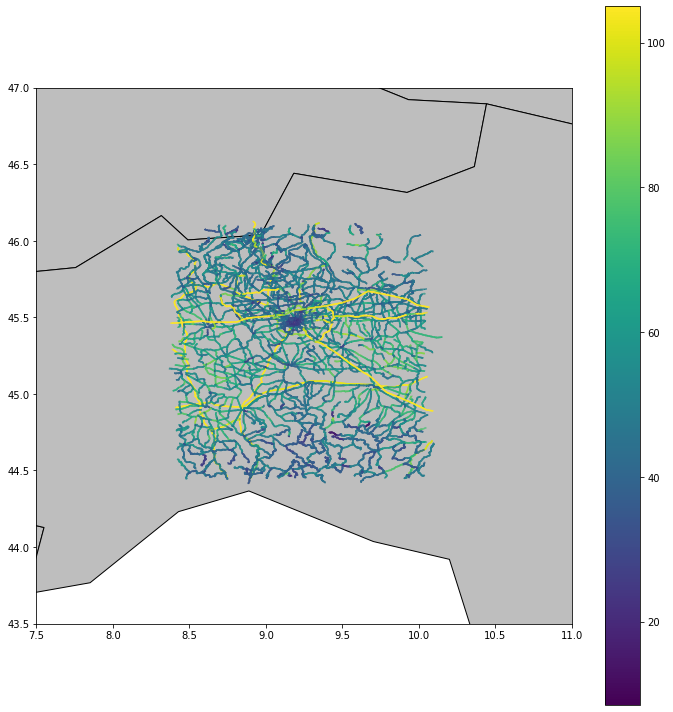

In [87]:
%%time 

fig, ax = plt.subplots(1,1, figsize=(10,10))
gdf.plot(ax=ax, column='JF', legend=True)
countries.plot(ax=ax, fc='#bebebe', ec='black', zorder=-10)
ax.set_xlim(area[0]-1, area[2]+1)
ax.set_ylim(area[1]-1, area[3]+1)
plt.tight_layout()
# plt.savefig('paris_traffic.png', dpi=240)

In [88]:
# LUR HELPER FUNCTIONS

import shapely as shp
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from rasterstats import zonal_stats
from datetime import datetime
import rasterio as rio
import rioxarray as rx
import os

def create_grid(region, size=1000, crs='epsg:32643'):
    '''Create vector grid of specified size over specified region.'''

    # total area for the grid
    if type(region) in [list, tuple]:
        xmin, ymin, xmax, ymax = region
        
    elif type(region) in [gpd.geodataframe.GeoDataFrame]:
        if region.crs == None:
            region = region.set_crs('epsg:4326')
        xmin, ymin, xmax, ymax = region.to_crs(crs).total_bounds
        
    elif type(region) in [shp.geometry.Polygon]:
        xmin, ymin, xmax, ymax = region.bounds    

    elif type(region) == str:
        districts = gpd.read_file('../LUR/india-dist-2011-highres.geojson')
        districts = districts.to_crs(crs)
        if region.lower() in districts.NAME_1.str.lower().values:
            xmin, ymin, xmax, ymax = districts[districts.NAME_1.str.lower() == region.lower()].total_bounds
        
        states =  gpd.read_file('../LUR/india_highres.geojson')
        states = states.to_crs(crs)
    elif region.lower() in states.NAME_1.str.lower().values:
        xmin, ymin, xmax, ymax = states[states.NAME_1.str.lower() == region.lower()].total_bounds
    else:
        return 'No region found.'
        
    # grid size
    cell_size = size    # 1 km grid

    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            # bounds
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append(shp.geometry.box(x0, y0, x1, y1))

    grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)
    
    return grid

def road_length(source_gdf, intersecting_gdf, col_name=None, buffer=None, weights=None):
    """
    Conduct spatial intersection using spatial index for candidates GeoDataFrame to make queries faster.
    Note, with this function, you can have multiple Polygons in the 'intersecting_gdf' and it will return all the points
    intersect with ANY of those geometries.
    """

    if source_gdf.crs != intersecting_gdf.crs:
        crs = intersecting_gdf.crs
        source_gdf = source_gdf.set_crs('epsg:4326').to_crs(crs)
    else:
        crs = 'epsg:4326'
        
    source_sindex = source_gdf.sindex
    
    if col_name == None:
        col_name = 'road_length_in_buffer_'
    
    copy = intersecting_gdf.copy()
    
    if buffer != None:
        copy.geometry = copy.buffer(buffer).geometry
    
    for index, row in copy.iterrows():
        if index%10==0:
            print(index)
        
        possible_matches_index = []

        bounds = row.geometry.bounds
        
        c = list(source_sindex.intersection(bounds))
        possible_matches_index += c

        # Get unique candidates
        unique_candidate_matches = list(set(possible_matches_index))
        possible_matches = source_gdf.iloc[unique_candidate_matches]

        # Conduct the actual intersection
        result = possible_matches.loc[possible_matches.intersects(row.geometry)]

        if result.shape[0] > 0:
#             if type(result.geometry.values[0]) == shp.geometry.MultiLineString:
#                 multi = gpd.GeoDataFrame(geometry=[gpd.GeoSeries(result.geometry)])
#                 multi.geometry = multi.set_crs(crs).geometry
#             else:
#             multi = shp.geometry.MultiLineString([*result.geometry])
            multi = result.unary_union
            multi = gpd.GeoDataFrame(geometry=[multi])
            multi.crs = crs
                
            if weights == None:
                clipped = gpd.clip(multi, copy.iloc[index:index+1])
                if len(clipped.geometry) == 0:
                    length = 0
                else:
                    length = clipped.unary_union.length
                copy.loc[index, col_name] = length
            else:
                clipped = gpd.clip(multi, copy.iloc[index:index+1])
#                 print(clipped.shape)
                lengths = ((clipped.length) * (source_gdf.iloc[clipped.index.tolist()][weights]))
#                 print(lengths)
                copy.loc[index, col_name] = lengths.sum()
                
        elif result.shape[0] == 0:
            copy.loc[index, col_name] = 0
#         print()
    copy.geometry = intersecting_gdf.geometry
    return copy

def dist_to_road(road_gdf, grid_gdf, col_name=None):
    """
    Conduct spatial intersection using spatial index for candidate GeoDataFrame to make queries faster.
    Note, with this function, you can have multiple Polygons in the 'intersecting_gdf' and it will return all the points
    intersect with ANY of those geometries.
    """
    
    if road_gdf.crs != grid_gdf.crs:
        crs = grid_gdf.crs
        road_gdf.crs = 'epsg:4326'
        road_gdf = road_gdf.to_crs(crs)
    
    if col_name == None:
        col_name = 'dist_to_road_'
    
    if len(road_gdf) < 10000:
        print('Using direct distance function.')
        grid_gdf[col_name] = grid_gdf.distance(road_gdf.unary_union)
        return grid_gdf
    
    else:
        print('Using spatial index.')
        source_sindex = road_gdf.sindex
        
        for index, row in grid_gdf.iterrows():
#             print("\nIndex: ", index)
            i = 0
            while True:
                possible_matches_index = []

                bounds = tuple(np.add(grid_gdf.geometry[index].bounds, [-500*i, -500*i, 500*i, 500*i]))
#                 print('Bounds: ', bounds)
                                
                c = list(source_sindex.intersection(bounds))
                possible_matches_index += c

                # Get unique candidates
                unique_candidate_matches = list(set(possible_matches_index))
                possible_matches = road_gdf.iloc[unique_candidate_matches]
#                 print("No. of possible matches: ", len(possible_matches))
#                 print('Possible matches index: ', possible_matches_index)
                if len(possible_matches) == 0:
                    i += 1
                    continue
                
                else:
#                     print(possible_matches)
                    if possible_matches.geometry.unary_union.intersects(shp.geometry.box(*bounds)):
                        result = possible_matches.unary_union.distance(row.geometry)
                        grid_gdf.loc[index, col_name] = result
                        break
                        
                    else:
#                         print('Possible matches, but no intersection.')
                        i += 1
#                         print('New i: ', i)
                        continue
    
        return grid_gdf
    

In [89]:
grid = create_grid(area, size=0.1, crs='epsg:4326')

In [90]:
%%time
gdf_ = road_length(gdf, grid, weights='JF', col_name='road')

0


<ipython-input-88-15dd9039dcfd>:120: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lengths = ((clipped.length) * (source_gdf.iloc[clipped.index.tolist()][weights]))


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
CPU times: user 1min 27s, sys: 1.13 s, total: 1min 28s
Wall time: 11min 45s


In [92]:
%%time

zonal = zonal_stats(gdf_, './nox_mean.tif')

/opt/conda/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


CPU times: user 1.71 s, sys: 107 ms, total: 1.82 s
Wall time: 3min 33s


In [93]:
results_df = gdf_.join(pd.DataFrame(zonal))

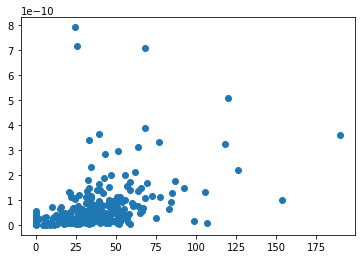

In [94]:
plt.scatter(results_df['road'], results_df['mean'])

In [95]:
from sklearn.metrics import r2_score

In [96]:
road_values = results_df['road']
nox_values = results_df['mean']

In [97]:
import scipy.stats as ss

In [98]:
ss.pearsonr(road_values, nox_values)[0]

0.3852509382266498

___

In [79]:
da = gc.make_geocube(results_df, measurements=['road', 'mean'], resolution=(0.1, 0.1))
da

<xarray.Dataset>
Dimensions:      (x: 16, y: 17)
Coordinates:
  * y            (y) float64 44.55 44.65 44.75 44.85 ... 45.85 45.95 46.05 46.15
  * x            (x) float64 8.45 8.55 8.65 8.75 8.85 ... 9.65 9.75 9.85 9.95
    spatial_ref  int64 0
Data variables:
    road         (y, x) float64 16.93 13.45 42.5 17.72 20.58 ... 0.0 0.0 0.0 0.0
    mean         (y, x) float64 9.164e-12 3.529e-11 ... 2.325e-11 1.713e-11

Text(0.5, 1.0, 'nox_gridded')

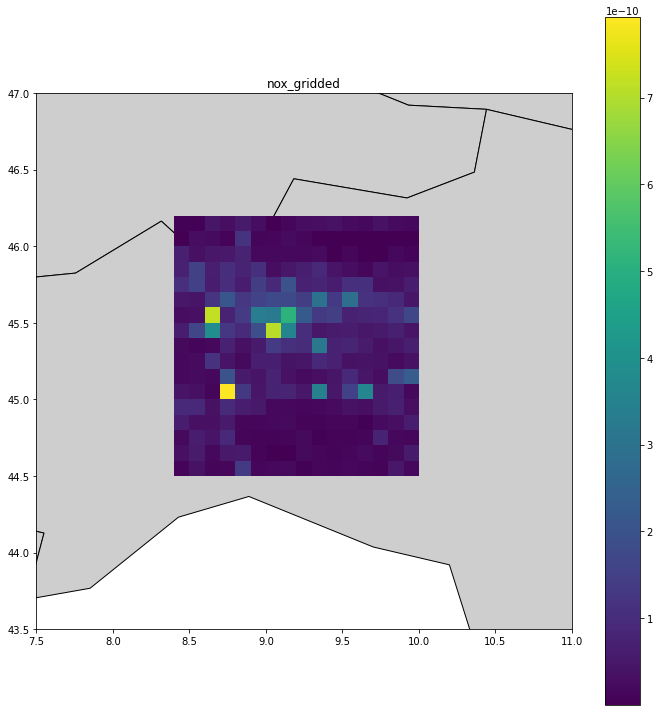

In [80]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
results_df.plot(ax=ax, column='mean', legend=True)
# nox__.plot(ax=ax)
countries.plot(ax=ax, fc='#cecece', ec='black', zorder=-10)
ax.set_xlim(area[0]-1, area[2]+1)
ax.set_ylim(area[1]-1, area[3]+1)
plt.tight_layout()
plt.title('nox_gridded')